
# Cassava Leaf Disease Detection


## Using Image Recognition to identify Disease

### Lynn Anderson


# Overview

The objective of this project was to use time series analysis to build a model that accurately predict future real estate values in San Jose, CA. Cassava roots are an important source of calories and nutrition for many people, especially in
sub-Saharan Africa. As the human population increases, it is increasingly important to prioritize
crop health, as fertile land is finite and precious. Identifying diseased plants and appropriately
treating them in a timely manner is important to ensure adequate yields. In this project, I will
train and develop an algorithm that, when given images of Cassava leaves, can accurately
classify that plant as healthy or belonging to a diseased plant. 
# Business Understanding

An agricultural company specializing in treating plant diseases is seeking to improve their effiency and accuracy in identifying diseased plants cassava plants. It is important they can accurately identify plants in need of treatment and determine the best solutions for their customers. 


# Data 

The data for this project was sourced  from the Tensorflow Cassava dataset -
https://www.tensorflow.org/datasets/catalog/cassava
The data consists of leaf images for the cassava plant depicting healthy and four disease
conditions- Cassava Mosaic Disease (CMD), Cassava Bacterial Blight (CBB), Cassava Greem
Mite (CGM), and Cassava Brown Streak Disease (CBSD). There are a total of 9,430 labeled
images, split into a training set (5,656 images), a test set (1,885 images) and a validation set
(1,889 images). The data consists of two folders- a training folder that in turn contains 5
subfolders for the respective images for the different 5 classes, and a test folder containing
validation and test images.

The number of images per class are unbalanced, with the two disease classes CMD and CBSD
having 72% of the images. Dealing with this will require some experimenting and manipulation. for example, I might need to generate additional training data, or train the algorithm to only
identify “diseased” vs normal plants.
The primary modeling techniques to be investigated will be those based on neural networks,
particularly, I anticipate, Multi Layer Perceptrons (MLPs) and Convolutional Neural Networks
(CNNs). The target variable is categorical, with 5 possible categories- normal or belonging to
one of the 4 diseases. Some essential libraries I plan to use include Tensorflow, Keras, Pandas,
and Numpy. A basic neural network will be the baseline model, with accuracy of the test data
used to determine model performance. I will explore models with different numbers of hidden
layers, different regularization techniques, and early stopping. I will also investigate pre-trained
networks and see if models based on those are higher performing.




# Data Preparation

In [4]:
# run if needed 
#pip install tensorflow-datasets
#pip install tensorflow
#pip install scikeras

In [5]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras.layers import Dense
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
#import tensorflow_datasets as tdfs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from keras import models
from keras import layers
from keras import regularizers
#from scikeras.wrappers import KerasRegressor
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras import optimizers

from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import PIL.Image as Image

#import tensorflow_addons as tfa

### Function to visualize model performance

In [6]:
def visualize_training_results(results):
    history = results.history
    plt.figure(figsize=(6, 4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(6, 4))
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


### preview files

In [7]:
print(os.listdir("data"))
#print(os.listdir("../data/train/"))

['cassava-disease.zip', 'extraimages.zip', 'random.txt', 'sample_submission_file.csv', 'test', 'test.zip', 'train', 'train.zip']


In [8]:
os.listdir('./data')

['cassava-disease.zip',
 'extraimages.zip',
 'random.txt',
 'sample_submission_file.csv',
 'test',
 'test.zip',
 'train',
 'train.zip']

#### unzip the file

In [9]:
from zipfile import ZipFile
  
# loading the temp.zip and creating a zip object
with ZipFile("data/cassava-disease.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path='./data')

#### unzip test folder

In [10]:
with ZipFile("data/test.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path='./data')

#### unzip train folder

In [11]:
with ZipFile("data/train.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path='./data')

#### preview files

In [12]:
print(os.listdir("./data"))

['cassava-disease.zip', 'extraimages.zip', 'random.txt', 'sample_submission_file.csv', 'test', 'test.zip', 'train', 'train.zip']


### preview image file names

In [13]:
import os
Id = []
for dirname, _, filenames in os.walk('./data/train'):
    for filename in filenames:
        Id.append(os.path.join(dirname, filename))
Id[:5]

['./data/train\\cbb\\train-cbb-0.jpg',
 './data/train\\cbb\\train-cbb-1.jpg',
 './data/train\\cbb\\train-cbb-10.jpg',
 './data/train\\cbb\\train-cbb-100.jpg',
 './data/train\\cbb\\train-cbb-101.jpg']

### Make into dataframe

In [14]:
train=pd.DataFrame()
train=train.assign(filename=Id)
train.head()

,filename
0,./data/train\cbb\train-cbb-0.jpg
1,./data/train\cbb\train-cbb-1.jpg
2,./data/train\cbb\train-cbb-10.jpg
3,./data/train\cbb\train-cbb-100.jpg
4,./data/train\cbb\train-cbb-101.jpg


### preview train folder

In [15]:
print(os.listdir("./data/train"))
print(np.shape(os.listdir("./data/train")))

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']
(5,)


There are 5 subfolders in the train directory

### Preprocess images

In [16]:
train_data_dir = 'data/train'
test_data_dir = 'data/test'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=3774)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=5656)

# Create the datasets
train_images, y_train = next(train_generator)
test_images, y_test = next(test_generator)

Found 3774 images belonging to 1 classes.
Found 5656 images belonging to 5 classes.


#### preview image labels

In [17]:
y_train

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [18]:
y_train[17]

array([0., 1., 0., 0., 0.], dtype=float32)

In [19]:
y_test

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

The test data is not labeled. 

In [20]:
print(np.shape(train_images))
print(np.shape(y_train))
print(np.shape(test_images))
print(np.shape(y_test))

(5656, 64, 64, 3)
(5656, 5)
(3774, 64, 64, 3)
(3774, 1)


### reshape images

In [21]:
train_img_unrow = train_images.reshape(5656, -1)
test_img_unrow = test_images.reshape(3774, -1)

# Preview the shape of train_img_unrow
np.shape(train_img_unrow)

(5656, 12288)

#### normalize pixel values

In [22]:
train_img_unrow /= 255.
test_img_unrow /= 255.

## train test split

In [23]:
final_train, final_test, train_labels, test_labels= train_test_split(train_img_unrow, y_train, test_size=0.2, random_state=42,shuffle=True)


# Modeling

## img class w MLPs

### basic network

In [24]:
#instantiate model
model_1 = models.Sequential()
model_1.add(layers.Dense(256, activation='tanh', input_shape=(12288,)))
model_1.add(layers.Dense(5, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])


In [25]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3145984   
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 3147269 (12.01 MB)
Trainable params: 3147269 (12.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
results_1 = model_1.fit(final_train, 
                        train_labels,
                        epochs=5,
                        batch_size=64,
                        validation_data=(final_test, test_labels))


Epoch 1/5


71/71 [==============================] - 4s 39ms/step - loss: 1.5439 - acc: 0.4337 - val_loss: 1.3315 - val_acc: 0.4867
Epoch 2/5
71/71 [==============================] - 2s 33ms/step - loss: 1.3318 - acc: 0.4655 - val_loss: 1.3165 - val_acc: 0.4859
Epoch 3/5
71/71 [==============================] - 3s 38ms/step - loss: 1.3069 - acc: 0.4752 - val_loss: 1.2811 - val_acc: 0.4920
Epoch 4/5
71/71 [==============================] - 3s 35ms/step - loss: 1.2949 - acc: 0.4766 - val_loss: 1.3447 - val_acc: 0.4850
Epoch 5/5
71/71 [==============================] - 2s 35ms/step - loss: 1.2851 - acc: 0.4794 - val_loss: 1.4075 - val_acc: 0.2889


With a training accuracy of 48.5% and testing accuracy of 47%, there is lots of room for improvement. 

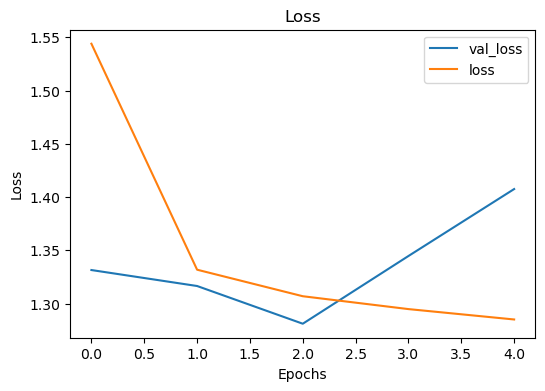

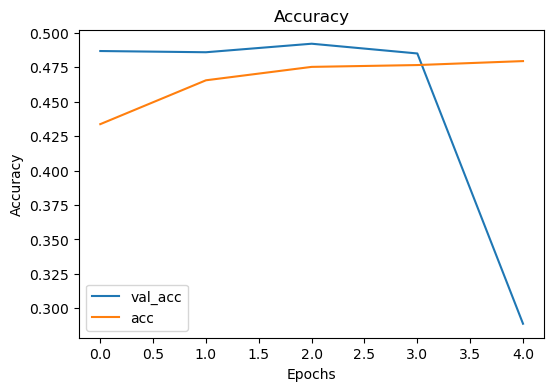

In [27]:
visualize_training_results(results_1)

## Network model with 2 hidden layers

In [28]:
np.random.seed(123)
model_2 = models.Sequential()
model_2.add(layers.Dense(32, activation='relu', input_shape=(12288,))) 
# 2 hidden layers
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dense(8, activation='relu'))
model_2.add(layers.Dense(5, activation='sigmoid'))
model_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

results_2 = model_2.fit(final_train,
                    train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_data=(final_test, test_labels))

Epoch 1/50
142/142 [==============================] - 3s 11ms/step - loss: 0.4832 - acc: 0.4509 - val_loss: 0.4428 - val_acc: 0.4832
Epoch 2/50
142/142 [==============================] - 1s 9ms/step - loss: 0.4410 - acc: 0.4666 - val_loss: 0.4325 - val_acc: 0.4832
Epoch 3/50
142/142 [==============================] - 1s 10ms/step - loss: 0.4359 - acc: 0.4666 - val_loss: 0.4307 - val_acc: 0.4832
Epoch 4/50
142/142 [==============================] - 1s 9ms/step - loss: 0.4344 - acc: 0.4666 - val_loss: 0.4308 - val_acc: 0.4832
Epoch 5/50
142/142 [==============================] - 1s 10ms/step - loss: 0.4340 - acc: 0.4666 - val_loss: 0.4287 - val_acc: 0.4832
Epoch 6/50
142/142 [==============================] - 1s 9ms/step - loss: 0.4334 - acc: 0.4666 - val_loss: 0.4290 - val_acc: 0.4832
Epoch 7/50
142/142 [==============================] - 1s 9ms/step - loss: 0.4324 - acc: 0.4666 - val_loss: 0.4285 - val_acc: 0.4832
Epoch 8/50
142/142 [==============================] - 1s 9ms/step - loss:

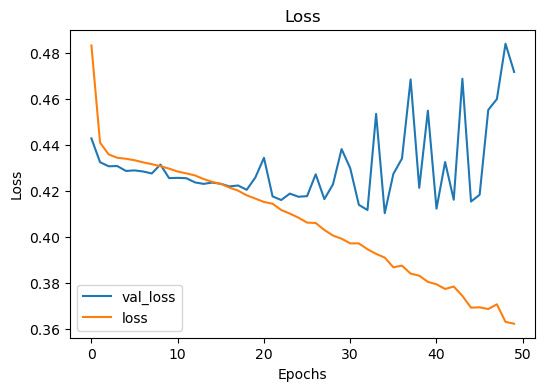

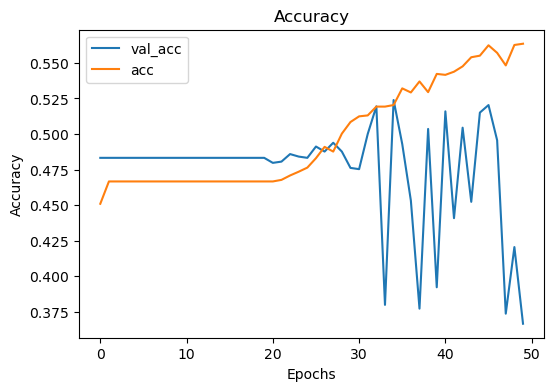

In [29]:
visualize_training_results(results_2)

comments - after 10 eopochs.....


## CNN

In [32]:
cnn_train, cnn_test, cnn_train_labels, cnn_test_labels= train_test_split(train_images, y_train, test_size=0.2, random_state=42,shuffle=True)


In [34]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64, 64, 3)))  ### 64, 64, 3??????????
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(5, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])
cnn_results = cnn_model.fit(cnn_train,
                            cnn_train_labels, 
                            epochs=10,
                            batch_size=12,
                            validation_data=(cnn_test, cnn_test_labels))

Epoch 1/10
377/377 [==============================] - 9s 23ms/step - loss: 0.4422 - acc: 0.4666 - val_loss: 0.4254 - val_acc: 0.4832
Epoch 2/10
377/377 [==============================] - 13s 33ms/step - loss: 0.4300 - acc: 0.4668 - val_loss: 0.4255 - val_acc: 0.4832
Epoch 3/10
377/377 [==============================] - 12s 32ms/step - loss: 0.4282 - acc: 0.4666 - val_loss: 0.4222 - val_acc: 0.4832
Epoch 4/10
377/377 [==============================] - 12s 32ms/step - loss: 0.4264 - acc: 0.4668 - val_loss: 0.4191 - val_acc: 0.4832
Epoch 5/10
377/377 [==============================] - 12s 31ms/step - loss: 0.4232 - acc: 0.4699 - val_loss: 0.4167 - val_acc: 0.4841
Epoch 6/10
377/377 [==============================] - 9s 24ms/step - loss: 0.4202 - acc: 0.4752 - val_loss: 0.4115 - val_acc: 0.4867
Epoch 7/10
377/377 [==============================] - 9s 24ms/step - loss: 0.4150 - acc: 0.4989 - val_loss: 0.4047 - val_acc: 0.5150
Epoch 8/10
377/377 [==============================] - 8s 22ms/ste

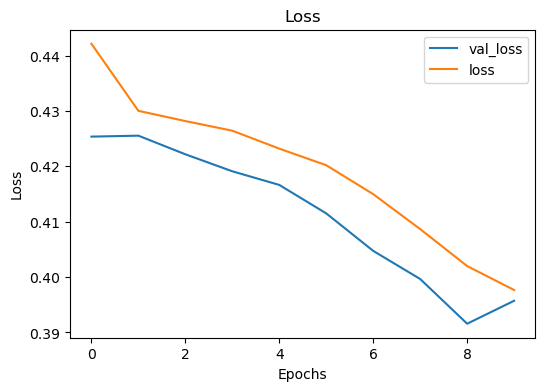

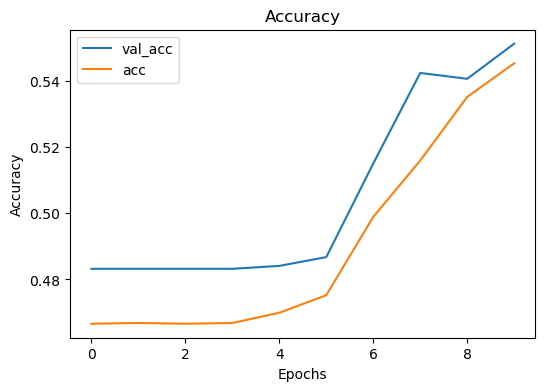

In [35]:
visualize_training_results(cnn_results)

## Early stopping tuning-neural-networks-with-regularization-lab

In [ ]:
# Import EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
#train
model = model.fit(final_train, 
                          train_labels,
                          epochs=10, 
                          callbacks=early_stopping, 
                          batch_size=32, 
                          validation_data=(final_test, test_labels))
# eval
results = saved_model.evaluate(X_train_tokens, y_train_lb)


## L2 reg.

In [38]:
# Import regularizers
from keras import regularizers

L2_model = models.Sequential()

# Add the input and first hidden layer
L2_model.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(12288,)))

# Add another hidden layer
L2_model.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Add an output layer
L2_model.add(layers.Dense(5, activation='softmax'))

# Compile the model
L2_model.compile(optimizer='SGD', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
L2_model_results = L2_model.fit(final_train, 
                            train_labels, 
                            epochs=10, 
                            batch_size=64, 
                            validation_data=(final_test, test_labels))

Epoch 1/10
71/71 [==============================] - 1s 15ms/step - loss: 2.0336 - acc: 0.4525 - val_loss: 1.9877 - val_acc: 0.4850
Epoch 2/10
71/71 [==============================] - 1s 12ms/step - loss: 1.9903 - acc: 0.4686 - val_loss: 1.9556 - val_acc: 0.4841
Epoch 3/10
71/71 [==============================] - 1s 8ms/step - loss: 1.9694 - acc: 0.4728 - val_loss: 1.9447 - val_acc: 0.4929
Epoch 4/10
71/71 [==============================] - 1s 8ms/step - loss: 1.9483 - acc: 0.4790 - val_loss: 1.9273 - val_acc: 0.4903
Epoch 5/10
71/71 [==============================] - 1s 9ms/step - loss: 1.9292 - acc: 0.4801 - val_loss: 1.9494 - val_acc: 0.4867
Epoch 6/10
71/71 [==============================] - 1s 8ms/step - loss: 1.9104 - acc: 0.4812 - val_loss: 1.8977 - val_acc: 0.5009
Epoch 7/10
71/71 [==============================] - 1s 8ms/step - loss: 1.8911 - acc: 0.4894 - val_loss: 1.9208 - val_acc: 0.4894
Epoch 8/10
71/71 [==============================] - 1s 8ms/step - loss: 1.8738 - acc: 0.

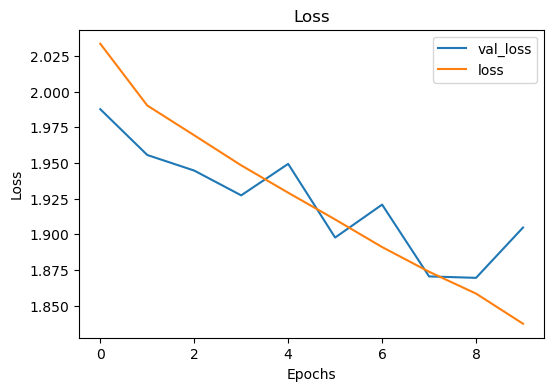

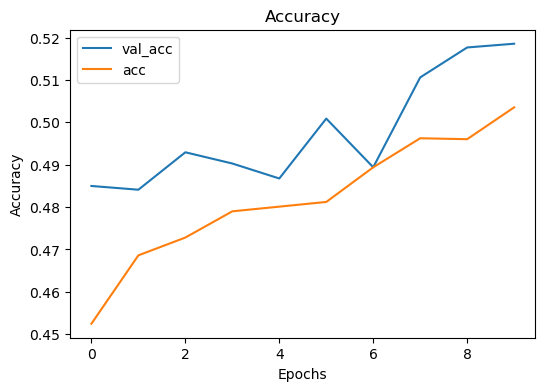

In [39]:
visualize_training_results(L2_model_results)

## L1 reg

In [40]:

L1_model = models.Sequential()

# Add the input and first hidden layer
L1_model.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.005), input_shape=(12288,)))

# Add a hidden layer
L1_model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))

# Add an output layer
L1_model.add(layers.Dense(5, activation='softmax'))

# Compile the model
L1_model.compile(optimizer='SGD', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
L1_model_val = L1_model.fit(final_train, 
                            train_labels,
                            epochs=150, 
                            batch_size=256, 
                            validation_data=(final_test, test_labels))

Epoch 1/150
18/18 [==============================] - 1s 36ms/step - loss: 34.8727 - acc: 0.4370 - val_loss: 33.3682 - val_acc: 0.4850
Epoch 2/150
18/18 [==============================] - 0s 23ms/step - loss: 32.1657 - acc: 0.4660 - val_loss: 30.7556 - val_acc: 0.4832
Epoch 3/150
18/18 [==============================] - 0s 21ms/step - loss: 29.6145 - acc: 0.4673 - val_loss: 28.2706 - val_acc: 0.4832
Epoch 4/150
18/18 [==============================] - 0s 22ms/step - loss: 27.1821 - acc: 0.4662 - val_loss: 25.9114 - val_acc: 0.4850
Epoch 5/150
18/18 [==============================] - 0s 19ms/step - loss: 24.8567 - acc: 0.4664 - val_loss: 23.6469 - val_acc: 0.4850
Epoch 6/150
18/18 [==============================] - 0s 21ms/step - loss: 22.6533 - acc: 0.4675 - val_loss: 21.4936 - val_acc: 0.4832
Epoch 7/150
18/18 [==============================] - 0s 26ms/step - loss: 20.5601 - acc: 0.4699 - val_loss: 19.4730 - val_acc: 0.4841
Epoch 8/150
18/18 [==============================] - 0s 19ms/s

18/18 [==============================] - 0s 17ms/step - loss: 2.0689 - acc: 0.4666 - val_loss: 2.0228 - val_acc: 0.4832
Epoch 63/150
18/18 [==============================] - 0s 17ms/step - loss: 2.0484 - acc: 0.4666 - val_loss: 2.0270 - val_acc: 0.4832
Epoch 64/150
18/18 [==============================] - 0s 17ms/step - loss: 2.0405 - acc: 0.4666 - val_loss: 2.0125 - val_acc: 0.4832
Epoch 65/150
18/18 [==============================] - 0s 18ms/step - loss: 2.0313 - acc: 0.4666 - val_loss: 2.0117 - val_acc: 0.4832
Epoch 66/150
18/18 [==============================] - 0s 18ms/step - loss: 2.0261 - acc: 0.4666 - val_loss: 2.0154 - val_acc: 0.4832
Epoch 67/150
18/18 [==============================] - 0s 22ms/step - loss: 2.0207 - acc: 0.4666 - val_loss: 2.0205 - val_acc: 0.4832
Epoch 68/150
18/18 [==============================] - 1s 30ms/step - loss: 2.0174 - acc: 0.4666 - val_loss: 1.9987 - val_acc: 0.4832
Epoch 69/150
18/18 [==============================] - 0s 19ms/step - loss: 2.0181 

18/18 [==============================] - 0s 27ms/step - loss: 1.7895 - acc: 0.4666 - val_loss: 1.8211 - val_acc: 0.4832
Epoch 124/150
18/18 [==============================] - 1s 29ms/step - loss: 1.7821 - acc: 0.4666 - val_loss: 1.7682 - val_acc: 0.4832
Epoch 125/150
18/18 [==============================] - 1s 30ms/step - loss: 1.7827 - acc: 0.4666 - val_loss: 1.7606 - val_acc: 0.4832
Epoch 126/150
18/18 [==============================] - 1s 35ms/step - loss: 1.7717 - acc: 0.4666 - val_loss: 1.7672 - val_acc: 0.4832
Epoch 127/150
18/18 [==============================] - 0s 22ms/step - loss: 1.7703 - acc: 0.4666 - val_loss: 1.7507 - val_acc: 0.4832
Epoch 128/150
18/18 [==============================] - 0s 25ms/step - loss: 1.7634 - acc: 0.4666 - val_loss: 1.7563 - val_acc: 0.4832
Epoch 129/150
18/18 [==============================] - 0s 21ms/step - loss: 1.7617 - acc: 0.4666 - val_loss: 1.7411 - val_acc: 0.4832
Epoch 130/150
18/18 [==============================] - 0s 27ms/step - loss: 

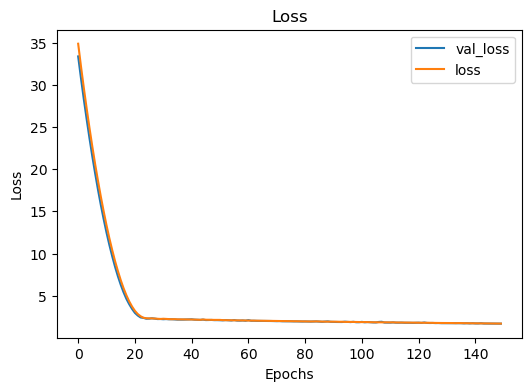

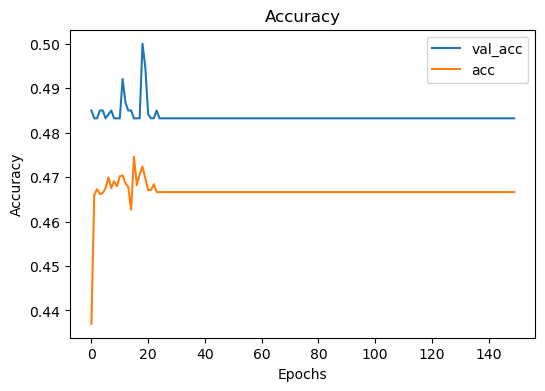

In [41]:
visualize_training_results(L1_model_val)

## dropout reg

In [42]:
dropout_model = models.Sequential()

# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
dropout_model.add(layers.Dropout(0.3, input_shape=(12288,)))

# Add the first hidden layer
dropout_model.add(layers.Dense(50, activation='relu'))

# Implement dropout to the first hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the second hidden layer
dropout_model.add(layers.Dense(25, activation='relu'))

# Implement dropout to the second hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the output layer
dropout_model.add(layers.Dense(5, activation='softmax'))


# Compile the model
dropout_model.compile(optimizer='SGD', 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])

# Train the model
dropout_model_val = dropout_model.fit(final_train, 
                                      train_labels,
                                      epochs=10, 
                                      batch_size=64, 
                                      validation_data=(final_test, test_labels))

Epoch 1/10
71/71 [==============================] - 2s 26ms/step - loss: 1.4710 - acc: 0.3979 - val_loss: 1.3635 - val_acc: 0.4850
Epoch 2/10
71/71 [==============================] - 2s 27ms/step - loss: 1.4200 - acc: 0.4337 - val_loss: 1.3619 - val_acc: 0.4832
Epoch 3/10
71/71 [==============================] - 1s 15ms/step - loss: 1.3953 - acc: 0.4509 - val_loss: 1.3750 - val_acc: 0.4832
Epoch 4/10
71/71 [==============================] - 1s 16ms/step - loss: 1.3871 - acc: 0.4609 - val_loss: 1.3217 - val_acc: 0.4832
Epoch 5/10
71/71 [==============================] - 1s 17ms/step - loss: 1.3792 - acc: 0.4633 - val_loss: 1.3645 - val_acc: 0.4832
Epoch 6/10
71/71 [==============================] - 1s 16ms/step - loss: 1.3676 - acc: 0.4666 - val_loss: 1.3388 - val_acc: 0.4832
Epoch 7/10
71/71 [==============================] - 1s 16ms/step - loss: 1.3709 - acc: 0.4704 - val_loss: 1.3356 - val_acc: 0.4832
Epoch 8/10
71/71 [==============================] - 2s 21ms/step - loss: 1.3541 - a

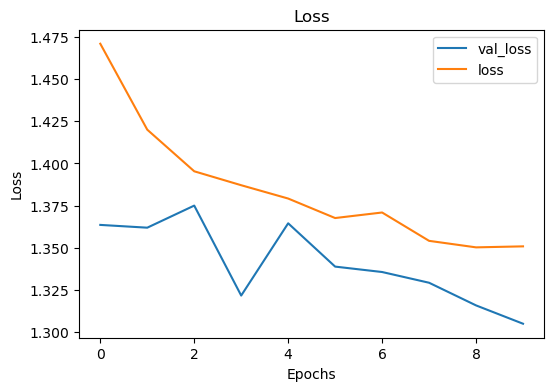

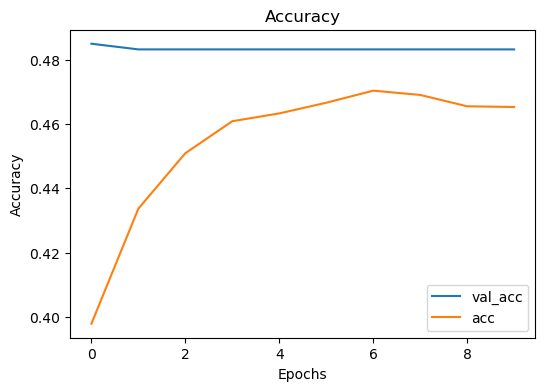

In [43]:
visualize_training_results(dropout_model_val)

## CNN from scratch

In [35]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

## Tuning models- pipeline stuff- keras wrapper?

In [36]:
def create_baseline_model():
    
    # Initialize model
    model = models.Sequential()

    # First hidden layer
    model.add(layers.Dense(10, activation='relu', input_shape=(n_features,)))

    # Second hidden layer
    model.add(layers.Dense(5, activation='relu'))

    # Output layer
    model.add(layers.Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer='SGD', 
                  loss='mse',  
                  metrics=['mse']) 
    
    # Return the compiled model
    return model

In [37]:
"""keras_wrapper_1 = KerasRegressor(create_baseline_model,  
                                 epochs=150, 
                                 batch_size=256, 
                                 verbose=0)"""

'keras_wrapper_1 = KerasRegressor(create_baseline_model,  \n                                 epochs=150, \n                                 batch_size=256, \n                                 verbose=0)'

### intermediate activation functions

### display img

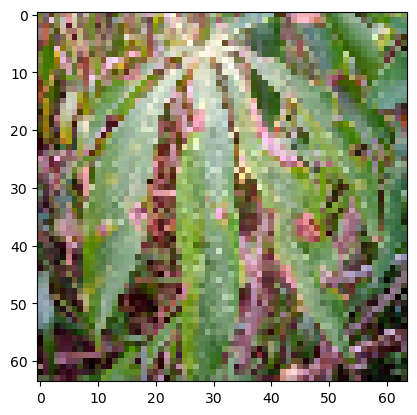

In [46]:
plt.imshow(train_images[0])
plt.show()




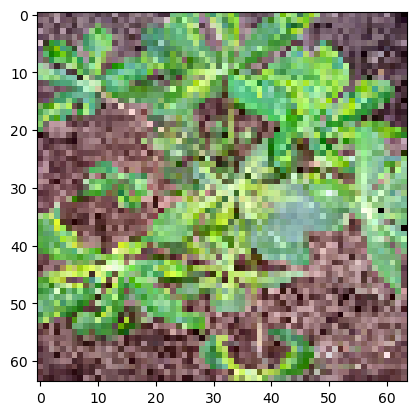

In [47]:

plt.imshow(test_images[0])
plt.show()


## visualize layers

In [48]:
layer_outputs = [layer.output for layer in cnn_model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=cnn_model.input, outputs=layer_outputs)

cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        16416     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 6, 6, 64)         

177/177 [==============================] - 30s 167ms/step
(5656, 62, 62, 32)


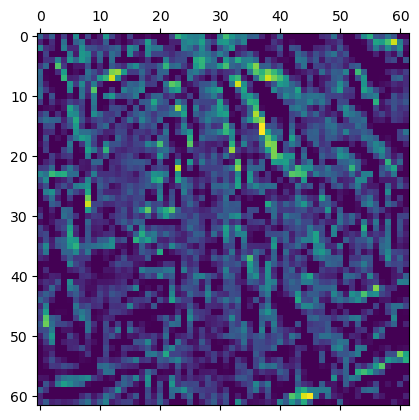

In [49]:
# Returns an array for each activation layer
activations = activation_model.predict(train_images)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

## channel 30

In [50]:
# Repeating the process for another channel (the 30th)
activations = activation_model.predict(train_images)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

177/177 [==============================] - 54s 303ms/step


MemoryError: Unable to allocate 2.59 GiB for an array with shape (5656, 62, 62, 32) and data type float32

## channel i

In [ ]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

### channel 29 for every layer

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 29], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

### viz act lab - plot feature maps

In [ ]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Create a model for displaying the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

# Extract Layer Names for Labelling
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_cols = 16
n_rows = math.ceil(total_features / n_cols)


iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_cols
        column = iteration % n_cols
    
        ax = axes[row, column]

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std() 
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.savefig('Intermediate_Activations_Visualized.pdf')
plt.show()

## normalization tuning-neural-networks-with-normalization-lab